In [6]:
#Python version
!python --version

Python 3.8.5


In [19]:
#Install uninstalled modules, comment if it's already installed

#!pip install stable-baselines[mpi]
#!pip install ipykernel
#!pip install MetaTrader5==5.0.34
#!pip install gym
#!pip install gym-anytrading
!pip install tensorflow==1.15.0
!pip install quantstats

ERROR: Could not find a version that satisfies the requirement tensorflow==1.15.0 (from versions: 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1, 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0)
ERROR: No matching distribution found for tensorflow==1.15.0


In [21]:
#Import needed modules
import gym
import gym_anytrading
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK

import numpy as np
import quantstats as qs

from stable_baselines.a2c import A2C
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpLstmPolicy

import matplotlib.pyplot as plt
import pandas as pd

import random, datetime, os, copy
import MetaTrader5 as mt5

In [9]:
# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    mt5.shutdown()
 
# display data on MetaTrader 5 version
print(mt5.version())

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

"""
# Initialize Metatrader on a certain day
if datetime.datetime.now() == weekdays:
    # now connect to another trading account specifying the password
    account = #Account number
    password = #Password number
    server = #Server name
    authorized=mt5.login(account, password, server)
    if authorized:
        # display trading account data 'as is'
        print(mt5.account_info())
        # display trading account data in the form of a list
        print("Show account_info()._asdict():")
        account_info_dict = mt5.account_info()._asdict()
        for prop in account_info_dict:
            print("  {}={}".format(prop, account_info_dict[prop]))
    else:
        print("failed to connect at account #{}, error code: {}".format(account, mt5.last_error()))
# shut down connection to the MetaTrader 5 terminal
else:
    mt5.shutdown()
"""

MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.34
initialize() failed, error code = (-10003, 'IPC initialize failed, MetaTrader 5 x64 not found')
(0, 0, '')


'\n# Initialize Metatrader on a certain day\nif datetime.datetime.now() == weekdays:\n    # now connect to another trading account specifying the password\n    account = #Account number\n    password = #Password number\n    server = #Server name\n    authorized=mt5.login(account, password, server)\n    if authorized:\n        # display trading account data \'as is\'\n        print(mt5.account_info())\n        # display trading account data in the form of a list\n        print("Show account_info()._asdict():")\n        account_info_dict = mt5.account_info()._asdict()\n        for prop in account_info_dict:\n            print("  {}={}".format(prop, account_info_dict[prop]))\n    else:\n        print("failed to connect at account #{}, error code: {}".format(account, mt5.last_error()))\n# shut down connection to the MetaTrader 5 terminal\nelse:\n    mt5.shutdown()\n'


env information:
> shape: (10, 2)
> df.shape: (6225, 5)
> prices.shape: (120,)
> signal_features.shape: (120, 2)
> max_possible_profit: 1.0459258410615082


> possible action: Discrete(2)
> observation space: Box(-inf, inf, (10, 2), float32)


> signal features:  [[ 1.05227e+00  0.00000e+00]
 [ 1.05282e+00  5.50000e-04]
 [ 1.05281e+00 -1.00000e-05]
 [ 1.05240e+00 -4.10000e-04]
 [ 1.05220e+00 -2.00000e-04]
 [ 1.05226e+00  6.00000e-05]
 [ 1.05193e+00 -3.30000e-04]
 [ 1.05161e+00 -3.20000e-04]
 [ 1.05172e+00  1.10000e-04]
 [ 1.05162e+00 -1.00000e-04]
 [ 1.04899e+00 -2.63000e-03]
 [ 1.04877e+00 -2.20000e-04]
 [ 1.04815e+00 -6.20000e-04]
 [ 1.04790e+00 -2.50000e-04]
 [ 1.04663e+00 -1.27000e-03]
 [ 1.04666e+00  3.00000e-05]
 [ 1.04738e+00  7.20000e-04]
 [ 1.04725e+00 -1.30000e-04]
 [ 1.04705e+00 -2.00000e-04]
 [ 1.04668e+00 -3.70000e-04]
 [ 1.04619e+00 -4.90000e-04]
 [ 1.04610e+00 -9.00000e-05]
 [ 1.04610e+00  0.00000e+00]
 [ 1.04552e+00 -5.80000e-04]
 [ 1.04637e+00  8.50000e-04]
 [ 1.04579

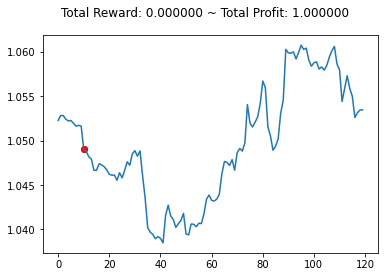

In [10]:
env = gym.make('forex-v0',
               df = FOREX_EURUSD_1H_ASK,
               window_size = 10,
               frame_bound = (10, 120), #Max 6225 Rows of data
               unit_side = 'right')

seed = 42
env.seed(seed)
eps = np.finfo(np.float32).eps.item()

print()
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())
print("\n")
print("> possible action:", env.action_space)
print("> observation space:", env.observation_space)
print("\n")
print("> signal features: ", env.signal_features)

env.reset() # Uncomment if you need it.
env.render()


In [73]:
print(env.df)
print("\n")
env.df.info()

                        Open     High      Low    Close        Volume
Time                                                                 
2017-01-01 22:00:00  1.05236  1.05253  1.05221  1.05227  1.435400e+08
2017-01-01 23:00:00  1.05227  1.05426  1.05226  1.05282  2.531400e+08
2017-02-01 00:00:00  1.05283  1.05283  1.05268  1.05281  1.314000e+08
2017-02-01 01:00:00  1.05282  1.05286  1.05225  1.05240  2.739400e+08
2017-02-01 02:00:00  1.05239  1.05240  1.05164  1.05220  2.581400e+08
...                      ...      ...      ...      ...           ...
2017-12-29 17:00:00  1.20224  1.20257  1.20191  1.20218  9.283300e+09
2017-12-29 18:00:00  1.20218  1.20242  1.20122  1.20139  7.366750e+09
2017-12-29 19:00:00  1.20139  1.20144  1.20073  1.20096  7.205770e+09
2017-12-29 20:00:00  1.20098  1.20109  1.19978  1.19982  6.679810e+09
2017-12-29 21:00:00  1.19984  1.20130  1.19931  1.20075  4.885530e+09

[6225 rows x 5 columns]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6225 entri

In [74]:
'''
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]
    prices = df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = df.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']].to_numpy()[start:end]
    return prices, signal_features

prices, signal_features = my_process_data(
            df = FOREX_EURUSD_1H_ASK,
            window_size = 10,
            frame_bound = (10, 800), #Max 6225 Rows of data
)

print(prices)
print("\n")
print(signal_features)
'''

'\ndef my_process_data(df, window_size, frame_bound):\n    start = frame_bound[0] - window_size\n    end = frame_bound[1]\n    prices = df.loc[:, \'Low\'].to_numpy()[start:end]\n    signal_features = df.loc[:, [\'Open\', \'High\', \'Low\', \'Close\', \'Volume\']].to_numpy()[start:end]\n    return prices, signal_features\n\nprices, signal_features = my_process_data(\n            df = FOREX_EURUSD_1H_ASK,\n            window_size = 10,\n            frame_bound = (10, 800), #Max 6225 Rows of data\n)\n\nprint(prices)\nprint("\n")\nprint(signal_features)\n'

info: {'total_reward': 348.3000000000412, 'total_profit': 0.9618007306900311, 'position': 0}


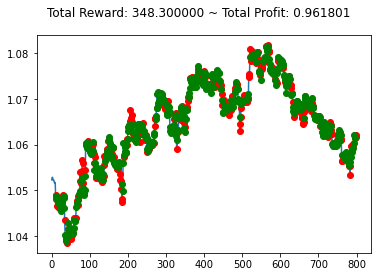

In [75]:
# Based on random actions

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()